In [ ]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt
from skimage.util import random_noise
import random
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Read in our dataset of 7128 grayscale landscape images. 

In [ ]:
landscape_dataset_raw = []
for i in range(0, 7128):
  print(i)
  img = cv2.imread('/content/drive/MyDrive/gray/{}.jpg'.format(i), cv2.IMREAD_GRAYSCALE)
  landscape_dataset_raw.append(img)

Streaming output truncated to the last 5000 lines.
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149
2150
2151
2152
2153
2154
2155
2156
2157
2158
2159
2160
2161
2162
2163
2164
2165
2166
2167
2168
2169
2170
2171
2172
2173
2174
2175
2176
2177
2178
2179
2180
2181
2182
2183
2184
2185
2186
2187
2188
2189
2190
2191
2192
2193
2194
2195
2196
2197
2198
2199
2200
2201
2202
2203
2204
2205
2206
2207
2208
2209
2210
2211
2212
2213
2214
2215
2216
2217
2218
2219
2220
2221
2222
2223
2224
2225
2226
2227
2228
2229
2230
2231
2232
2233
2234
2235
2236
2237
2238
2239
2240
2241
2242
2243
2244
2245
2246
2247
2248
2249
2250
2251
2252
2253
2254
2255
2256
2257
2258
2259
2260
2261
2262
2263
2264
2265
2266
2267
2268
2269
2270
2271
2272
2273
2274
2275
2276
2277
2278
2279
2280
2281
2282
2283
2284
2285
2286
2287
2288
2289
2290
2291
2292
2293
2294
2295
2296
2297
2298
2299
2300
2301
2302
2303
2304
2305
2306
2307
2308
2309
2310
2311
2312
2313
2314
2315
2316
2317

from this little script we made we can see that not every image in our dataset is 150x150 pixels. This will cause more dimensional errors in the future so we will remove these 23 images as croupted data. 

In [ ]:
index = 0
position = []
landscape_dataset = []

for img in landscape_dataset_raw:
  if img.shape != (150, 150):
    print("Shape is not 150x150 at {pos}, instead it is: {shape}".format(pos = index, shape = img.shape))
    position.append(i)
  elif img.shape == (150, 150):
    landscape_dataset.append(img)
  
  index += 1


print("The number of croupted images are: {}".format(len(position)))
print("The size of the original dataset: ", len(landscape_dataset_raw))
print("The size of the cleaned dataset: ", len(landscape_dataset))

Shape is not 150x150 at 223, instead it is: (140, 150)
Shape is not 150x150 at 619, instead it is: (113, 150)
Shape is not 150x150 at 624, instead it is: (110, 150)
Shape is not 150x150 at 1093, instead it is: (134, 150)
Shape is not 150x150 at 1804, instead it is: (76, 150)
Shape is not 150x150 at 2778, instead it is: (100, 150)
Shape is not 150x150 at 3105, instead it is: (111, 150)
Shape is not 150x150 at 3128, instead it is: (143, 150)
Shape is not 150x150 at 3251, instead it is: (124, 150)
Shape is not 150x150 at 3255, instead it is: (141, 150)
Shape is not 150x150 at 3321, instead it is: (136, 150)
Shape is not 150x150 at 3379, instead it is: (113, 150)
Shape is not 150x150 at 3416, instead it is: (108, 150)
Shape is not 150x150 at 3664, instead it is: (146, 150)
Shape is not 150x150 at 4014, instead it is: (145, 150)
Shape is not 150x150 at 4462, instead it is: (81, 150)
Shape is not 150x150 at 4467, instead it is: (111, 150)
Shape is not 150x150 at 5825, instead it is: (110, 15

First we will put together the Encoding Process

In [ ]:
#
# ENCODER
#

input_img = Input(shape=(150, 150, 1))

# Convolutional Layer 1
x = Conv2D(filters = 16, kernel_size = (3, 3), activation='relu', padding='same')(input_img)
# we will use 16 filters, a relu activation, and a 3 by 3 kernel.
# Padding='same' means we will be using zero padding if our filters don't fit 
print("Input Shape: ", x.shape)
x = MaxPooling2D(pool_size=(2,2), padding='same')(x)
# for now we will use a pool size of (2,2) and see how it performs, it could be a little small for our image size though..
print("Shape 1: ", x.shape)



# Convolutional Layer 2
x = Conv2D(filters = 8, kernel_size = (3, 3), activation='relu', padding='same')(x)
print(x.shape)
x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
print("Shape 2: ", x.shape)
# note we we make our first conv2D and feed in our input image then we feed its output for our Max_pooling function
# then we feed our Conv layer 1 into our Conv layer 2 and so on)



# Convolutional Layer 3
x = Conv2D(filters = 8, kernel_size = (3, 3), activation='relu', padding='same')(x)
print(x.shape)
encoded = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
print("Encoded shape = {}".format(encoded.shape))


Input Shape:  (None, 150, 150, 16)
Shape 1:  (None, 75, 75, 16)
(None, 75, 75, 8)
Shape 2:  (None, 38, 38, 8)
(None, 38, 38, 8)
Encoded shape = (None, 19, 19, 8)


And now the Decoder, This will be very simlar to how to made our encoder but in reverse order. 


In [ ]:
#
# DECODER
#
print("Encoded shape = {}".format(encoded.shape))
print("X shape = {}".format(x.shape))
x = Conv2D(8, (3,3), activation='relu', padding='same')(encoded)  # we pass it our encoded data that we just created
x = UpSampling2D((2,2))(x)
print("Shape 1: ", x.shape)
x = Conv2D(8, (3,3), activation='relu', padding='same')(x)
print("76", x.shape)
x = UpSampling2D((2,2))(x)
print("Shape 2: ", x.shape)
x = Conv2D(16, (3,3), activation='relu', padding='same')(x)
print(x.shape)
x = UpSampling2D((2,2))(x)
print("Shape 3: ", x.shape)
decoded = Conv2D(1, (3,3), activation='sigmoid')(x)
print("Decoded shape = {}".format(decoded.shape))

autoEncoder = Model(input_img, decoded)
autoEncoder.compile(optimizer='adadelta', loss='binary_crossentropy')


Encoded shape = (None, 19, 19, 8)
X shape = (None, 38, 38, 8)
Shape 1:  (None, 38, 38, 8)
76 (None, 38, 38, 8)
Shape 2:  (None, 76, 76, 8)
(None, 76, 76, 16)
Shape 3:  (None, 152, 152, 16)
Decoded shape = (None, 150, 150, 1)


In [ ]:
def add_gaussian(img, var):
    img_array = np.asarray(img)
    noisy_img = random_noise(img_array, mode="gaussian", var=var)
    noisy_img = (255 * noisy_img).astype(np.uint8)
    return noisy_img


def add_salt_and_pepper(img, probability):
    noisy_img = np.zeros(img.shape, np.uint8)
    threshold = 1 - probability

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            rand = random.random()
            if rand < probability:
                noisy_img[i][j] = 0
            elif rand > threshold:
                noisy_img[i][j] = 255
            else:
                noisy_img[i][j] = img[i][j]

    return noisy_img


def add_poisson(img, num):
    noise = np.random.poisson(num, img.shape)
    # noise = np.random.noraml(0, 0.3, (400, 500))*100
    noisy_img = img + noise
    noisy_img = noisy_img.astype(np.uint8)
    return noisy_img


running earlier tests we hae seen that this landscape dataset is a bit complex for our model and so to try and achive better results, we will make our data a fair bit simpler and not included any images with mixed noise.

In [ ]:
def add_noise(image):
    rand_noise_picker = random.randint(1, 3)

    if rand_noise_picker == 1:
        rand_var = random.uniform(0.02, 0.08)
        img_noise = add_gaussian(image, rand_var)
        effect = ["Gaussian", rand_var]
        noise_type = 1
        return img_noise, effect, noise_type
    elif rand_noise_picker == 2:
        rand_prob = random.uniform(0.01, 0.08)
        img_noise = add_salt_and_pepper(image, rand_prob)
        effect = ["S&P", rand_prob]
        noise_type = 2
        return img_noise, effect, noise_type
    elif rand_noise_picker == 3:
        rand_num = random.randint(5, 40)
        img_noise = add_poisson(image, rand_num)
        effect = ["Poisson", rand_num]
        noise_type = 3
        return img_noise, effect, noise_type
    



  Unlike in our SVM model, this time we will simply add noise to all the images. We will keep no clear images in our training dataset. This is because this time we are not predicting the presence of noise but denoising all the images we feed in. 
We will still keep all three types of noise, and if that proves to be too difficult for the network to handle then we can change it to a simpler dataset. 

In [ ]:
dataset_noisy = []
if_noise = []
effect = []
for data in landscape_dataset:
  noisy_img, noise_added, noise_type = add_noise(data)
  dataset_noisy.append(noisy_img)
  effect.append(noise_added)
  if_noise.append(noise_type)



7105


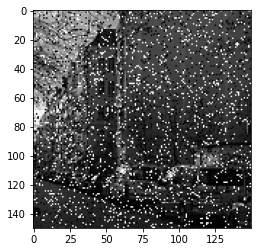

['S&P', 0.07254918294110171]
2


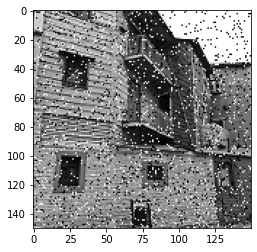

['S&P', 0.05314410218783608]
2


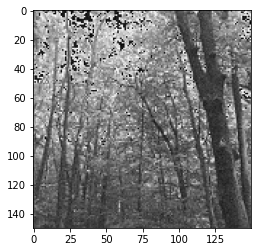

['Poisson', 32]
3


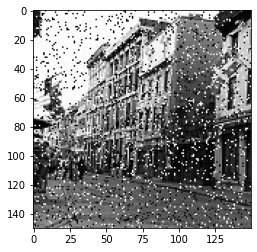

['S&P', 0.060413012670471104]
2


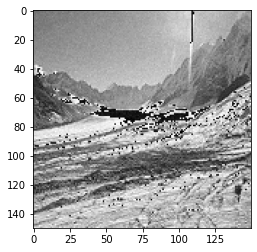

['Poisson', 28]
3


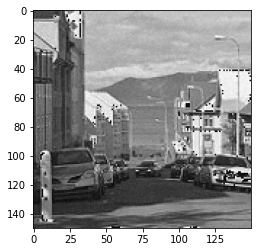

['Poisson', 15]
3


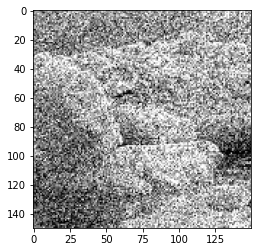

['Gaussian', 0.04838969917162707]
1


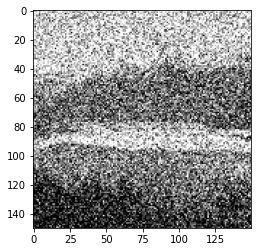

['Gaussian', 0.07978455240220274]
1


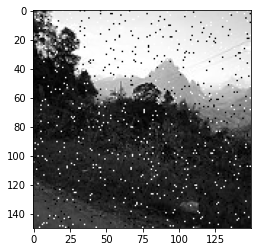

['S&P', 0.02256082624607677]
2


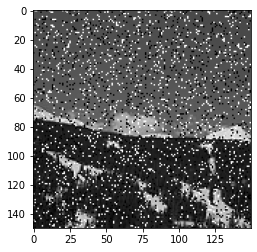

['S&P', 0.07190590274113892]
2


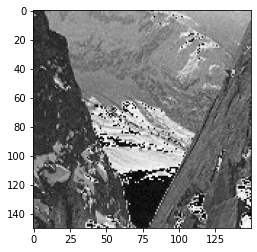

['Poisson', 31]
3


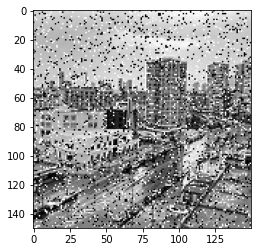

['S&P', 0.07197145093024876]
2


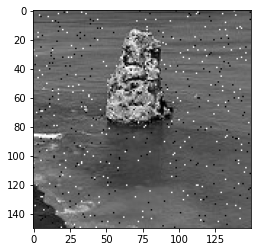

['S&P', 0.011230212581682403]
2


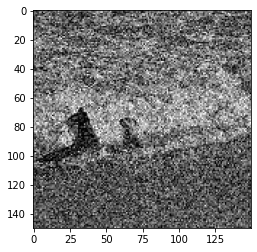

['Gaussian', 0.027777071790038785]
1


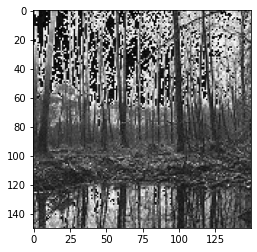

['Poisson', 20]
3


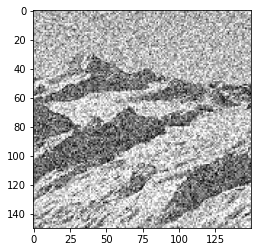

['Gaussian', 0.026531644269352582]
1


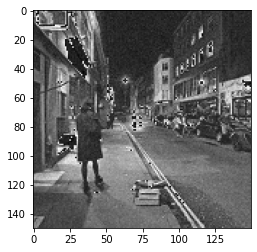

['Poisson', 37]
3


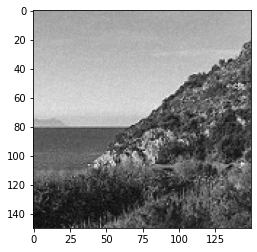

['Poisson', 16]
3


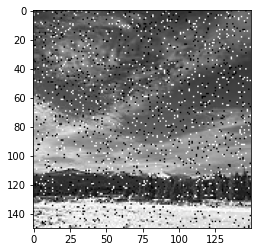

['S&P', 0.04405886756076194]
2


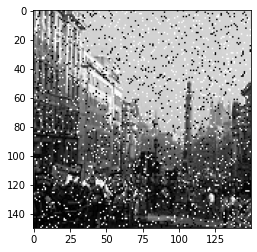

['S&P', 0.0552235405177729]
2


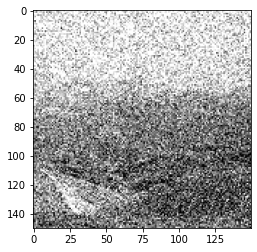

['Gaussian', 0.04757893905623974]
1


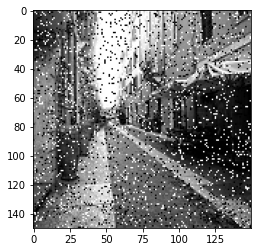

['S&P', 0.06965984199545343]
2


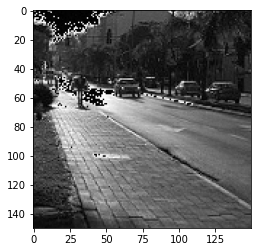

['Poisson', 5]
3


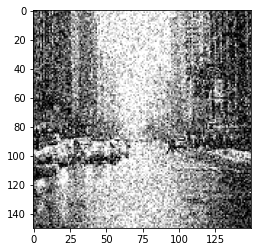

['Gaussian', 0.04097927354827114]
1


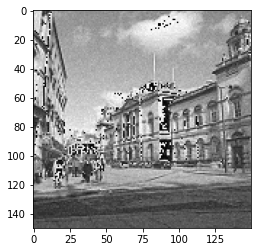

['Poisson', 40]
3


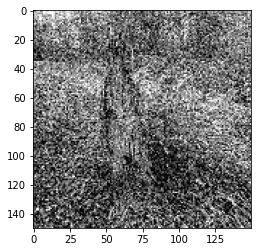

['Gaussian', 0.03758887813139635]
1


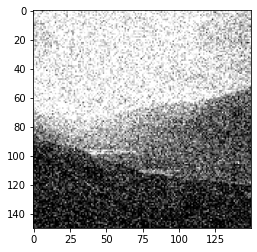

['Gaussian', 0.035921213801840865]
1


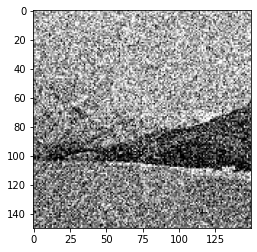

['Gaussian', 0.0542618633465783]
1


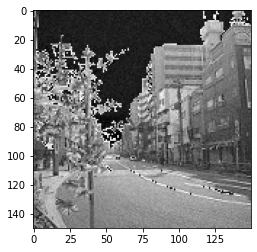

['Poisson', 31]
3


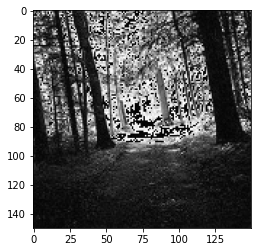

['Poisson', 9]
3


In [ ]:
print(len(effect))
count = 0
for img in dataset_noisy:
  if count == 30:
    break
  plt.imshow(img)
  plt.gray()
  plt.show()
  print(effect[count])
  print(if_noise[count])
  count += 1

Now that we have added noise to our dataset, we will reshape and normalize our data to fit our network 



1.   we first split our data, 80% train, 20% test
2.   we then reshape it to fir the shape of (x images, 150x150, 1) and turn it to a float type value



In [ ]:
print(len(dataset_noisy))
# print("Shape = (x images, 150x150 dim)")

X_train_noise = dataset_noisy[:int(len(dataset_noisy) * 0.80)]
X_test_noise = dataset_noisy[int(len(dataset_noisy) * 0.80):]
print(X_train_noise[1].shape)

X_train_noise = np.reshape(X_train_noise, (len(X_train_noise), 150, 150, 1))
X_test_noise = np.reshape(X_test_noise, (len(X_test_noise), 150, 150, 1))
X_train_noise = X_train_noise.astype("float32") / 255.0
X_test_noise = X_test_noise.astype("float32") / 255.0

print(X_train_noise.shape)
print(X_test_noise.shape)

7105
(150, 150)
(5684, 150, 150, 1)
(1421, 150, 150, 1)


Erlier we created a noisy dataset, for both training and testing and now we do the exact same and create a clean dataset

In [ ]:
print(len(landscape_dataset))

X_train_clean = landscape_dataset[:int(len(landscape_dataset) * 0.8)]
X_test_clean = landscape_dataset[int(len(landscape_dataset) * 0.8):]

X_train_clean = np.reshape(X_train_clean, (len(X_train_clean), 150, 150, 1))
X_test_clean = np.reshape(X_test_clean, (len(X_test_clean), 150, 150, 1))
X_train_clean = X_train_clean.astype("float32") / 255.0
X_test_clean = X_test_clean.astype("float32") / 255.0

print(len(X_train_clean))
print(X_train_clean.shape)
print(len(X_test_clean))
print(X_test_clean.shape)

7105
5684
(5684, 150, 150, 1)
1421
(1421, 150, 150, 1)


In [ ]:
print(X_train_noise.shape)
print(X_train_clean.shape)
print(X_test_noise.shape)
print(X_test_clean.shape)

(5684, 150, 150, 1)
(5684, 150, 150, 1)
(1421, 150, 150, 1)
(1421, 150, 150, 1)


Finally we fit our data, and run it through our network for a 100 epochs

In [ ]:
autoEncoder.fit(X_train_noise, X_train_clean,
                validation_data=(X_test_noise, X_test_clean),
                shuffle=True,
                epochs=100,
                batch_size=128
                )

Epoch 1/100
45/45 [==============================] - 168s 4s/step - loss: 0.6923 - val_loss: 0.6923
Epoch 2/100
45/45 [==============================] - 167s 4s/step - loss: 0.6922 - val_loss: 0.6922
Epoch 3/100
45/45 [==============================] - 166s 4s/step - loss: 0.6922 - val_loss: 0.6922
Epoch 4/100
45/45 [==============================] - 167s 4s/step - loss: 0.6922 - val_loss: 0.6921
Epoch 5/100
45/45 [==============================] - 167s 4s/step - loss: 0.6921 - val_loss: 0.6921
Epoch 6/100
45/45 [==============================] - 167s 4s/step - loss: 0.6921 - val_loss: 0.6920
Epoch 7/100
45/45 [==============================] - 167s 4s/step - loss: 0.6920 - val_loss: 0.6920
Epoch 8/100
45/45 [==============================] - 167s 4s/step - loss: 0.6919 - val_loss: 0.6919
Epoch 9/100
45/45 [==============================] - 167s 4s/step - loss: 0.6919 - val_loss: 0.6919
Epoch 10/100
45/45 [==============================] - 168s 4s/step - loss: 0.6918 - val_loss: 0.6918

Lastly we used our trained network to predict images without noise. Afterwards, we show a side by side of the original image with noise to the preditced image our neural network gives us.

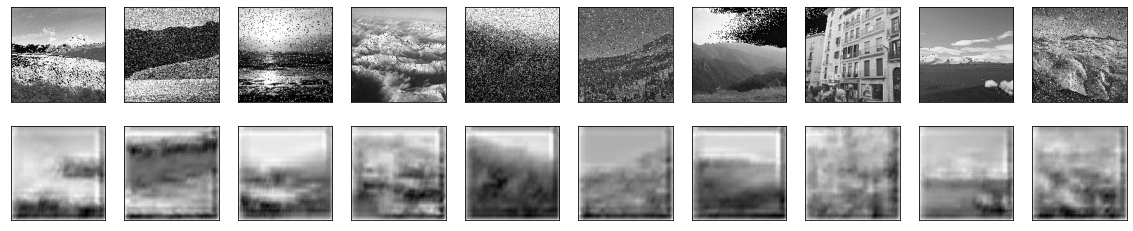

In [ ]:
decoded_images = autoEncoder.predict(X_test_clean)

plt.figure(figsize=(20, 4))
for i in range (10):
  sb = plt.subplot(2, 10, i+1)
  plt.imshow(X_test_noise[i].reshape(150, 150))
  plt.gray()
  sb.get_xaxis().set_visible(False)
  sb.get_yaxis().set_visible(False)

  sb = plt.subplot(2, 10, i+1+10)
  plt.imshow(decoded_images[i].reshape(150, 150))
  plt.gray()
  sb.get_xaxis().set_visible(False)
  sb.get_yaxis().set_visible(False)

plt.show()